# Predicting Future Sales

In [3]:
# Environment Setup
import numpy    as np
import pandas   as pd
import seaborn  as sns
import matplotlib.pyplot as plt
import sklearn  as skl
import datetime
from geopy.geocoders import Nominatim

from sklearn import pipeline      # Pipeline
from sklearn import preprocessing # OrdinalEncoder, LabelEncoder
from sklearn import impute
from sklearn import compose
from sklearn import model_selection # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import linear_model    # LogisticRegression
from sklearn import set_config

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [4]:
# Loading datasets
df_train = pd.read_csv('sales_train.csv')
df_test = pd.read_csv('test.csv')
shops = pd.read_csv('shops.csv')
items = pd.read_csv('items.csv')
items_cat = pd.read_csv('item_categories.csv')


## Data Cleaning


### Shops

In [35]:
# repeated shops IDs:
#10, 11
#39, 40
#0, 57
#1, 58
np.array(set(df_test.shop_id))

array({2, 3, 4, 5, 6, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59},
      dtype=object)

In [36]:
geo = Nominatim(user_agent='Fishermann')
def geoloc(city):
    gl = geo.geocode(city)
    try:
        return (gl.latitude, gl.longitude)
    except:
        return np.NaN

In [63]:

shops['online'] = [1 if x.shop_id in [9, 12, 55] else 0 for idx, x in shops.iterrows()]
shops['city'] = [x.split(' ')[0] if x.split(' ')[0] != 'РостовНаДону' else "Ростов На Дону" for x in shops.shop_name]
shops['coords'] = [geoloc(x) for x in shops.city]

In [88]:
cat_split = [x.split('-') for x in items_cat.item_category_name]
items_cat['category'] = [x[0] for x in cat_split]
items_cat['subcategory'] = [x[1] if len(x) > 1 else np.NaN for x in cat_split]
items_cat['type'] = np.NaN

In [89]:
def clean_cat_row(row):
    if 'Цифра' in row['category']:
        row.at['type'] = 'Цифра'
        row.at['category'] = row['category'][:row['category'].find("(")]
    if row['subcategory'] is not np.NaN and 'Цифра' in row['subcategory']:
        row.at['type'] = 'Цифра'
        if row.at['subcategory'] == 'Цифра':
            row.at['subcategory'] = np.NaN
        else:
            row.at['subcategory'] = row['subcategory'][:row['subcategory'].find("(")]
    cat = row['category'].split(' ')
    if len(cat) > 2 and cat[0] == 'Игры':
        sub = row['subcategory']
        row.at['subcategory'] = cat[1]
        row.at['type'] = sub
        row.at['category'] = 'Игры'
    elif len(cat) > 3:
        sub = 'KMI'
        row.at['subcategory'] = sub
        row.at['category'] = cat[0] + ' ' + cat[1]
    return row
items_cat = items_cat.apply(clean_cat_row, axis=1)

In [90]:
items_cat[:50]

,item_category_name,item_category_id,category,subcategory,type
0,PC - Гарнитуры/Наушники,0,PC,Гарнитуры/Наушники,NaN
1,Аксессуары - PS2,1,Аксессуары,PS2,NaN
2,Аксессуары - PS3,2,Аксессуары,PS3,NaN
3,Аксессуары - PS4,3,Аксессуары,PS4,NaN
4,Аксессуары - PSP,4,Аксессуары,PSP,NaN
5,Аксессуары - PSVita,5,Аксессуары,PSVita,NaN
6,Аксессуары - XBOX 360,6,Аксессуары,XBOX 360,NaN
7,Аксессуары - XBOX ONE,7,Аксессуары,XBOX ONE,NaN
8,Билеты (Цифра),8,Билеты,NaN,Цифра
9,Доставка товара,9,Доставка товара,NaN,NaN


In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [22]:
cv = CountVectorizer(dtype=np.dtype('B'))
A = cv.fit_transform(items.item_name)
cv2 = CountVectorizer(dtype=np.dtype('B'), ngram_range=(1,2))
B = cv2.fit_transform(items.item_name)
tfi = TfidfVectorizer(dtype=np.dtype(np.float32))
C = tfi.fit_transform(items.item_name)
tfi2 = TfidfVectorizer(dtype=np.dtype(np.float32), ngram_range=(1,2))
D = tfi2.fit_transform(items.item_name)

In [26]:
A, B, C, D

(<22170x18222 sparse matrix of type '<class 'numpy.uint8'>'
 	with 125389 stored elements in Compressed Sparse Row format>,
 <22170x64565 sparse matrix of type '<class 'numpy.uint8'>'
 	with 230430 stored elements in Compressed Sparse Row format>,
 <22170x18222 sparse matrix of type '<class 'numpy.float32'>'
 	with 125389 stored elements in Compressed Sparse Row format>,
 <22170x64565 sparse matrix of type '<class 'numpy.float32'>'
 	with 230430 stored elements in Compressed Sparse Row format>)

In [34]:
tfi2.get_feature_names()

['00',
 '00 07',
 '000',
 '000 dawn',
 '000 kill',
 '000 space',
 '000 баллов',
 '000 лет',
 '000 лье',
 '00002',
 '00002 microsoft',
 '00003',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009h',
 '00010',
 '00010 microsoft',
 '00011',
 '00012',
 '00013',
 '00014',
 '00014 xbox',
 '00015',
 '00016',
 '00017',
 '00018',
 '00019',
 '00020',
 '00021',
 '00022',
 '00024',
 '00028',
 '00029',
 '00032',
 '00036',
 '00038',
 '00039',
 '00046',
 '00052',
 '00052 microsof',
 '00053',
 '00055',
 '00059',
 '00061',
 '00062',
 '00076',
 '00077',
 '00082',
 '00095',
 '00097',
 '00110',
 '00114',
 '00117',
 '00119',
 '00120',
 '00121',
 '00122',
 '00146',
 '00149',
 '00160',
 '00194',
 '00194 spc9002blk',
 '001u',
 '002',
 '002 черный',
 '00219',
 '00223',
 '00225',
 '00243',
 '00262',
 '00262 4g',
 '00273',
 '00332',
 '00344',
 '00457',
 '005',
 '00544',
 '006',
 '006 digipack',
 '007',
 '007 blood',
 '007 digipack',
 '007 legends',
 '007 reloaded',
 '007 золото',
 '007 координаты',
 '0076',
 '0076 

In [38]:
# Converting the date from string to data object for convenient sorting
df_train['date'] = [datetime.date(int(x.split('.')[2]),int(x.split('.')[1]), int(x.split('.')[0])) for x in df_train['date']]
df_train['date']

0          2013-01-02
1          2013-01-03
2          2013-01-05
3          2013-01-06
4          2013-01-15
              ...    
2935844    2015-10-10
2935845    2015-10-09
2935846    2015-10-14
2935847    2015-10-22
2935848    2015-10-03
Name: date, Length: 2935849, dtype: object

In [39]:
# analysis
analysis = df_train.copy()

## day sales in rubles
analysis['day_sales'] = [int(p*q) for p, q in zip(analysis.item_price, analysis.item_cnt_day)]

## month sales in rubles
month_sales = np.array(analysis[['date_block_num', 'day_sales']].groupby(['date_block_num']).sum()['day_sales'])
analysis['month_sales'] = month_sales[analysis['date_block_num']]
analysis.head()

## Extracting item and category names
name_id = {x.at['item_id']: (x.at['item_name'], x.at['item_category_id']) for ix, x in items.iterrows()}
analysis['item_name'] = [name_id[x][0] for x in analysis['item_id']]
analysis['item_category_id'] = [name_id[x][1] for x in analysis['item_id']]
cat_id = {x.at['item_category_id']: x.at['item_category_name'] for ix, x in items_cat.iterrows()}
analysis['item_category'] = [cat_id[x] for x in analysis['item_category_id']]

## extracting shop features
shop_features = {x.at['shop_id']: [x.at['shop_name'], x.at['online'], x.at['city'], x.at['coords']] for ix, x in shops.iterrows()}
analysis['shop_name'] = [shop_features[x][0] for x in analysis['shop_id']]
analysis['online'] = [shop_features[x][1] for x in analysis['shop_id']]
analysis['city'] = [shop_features[x][2] for x in analysis['shop_id']]
analysis['coords'] = [shop_features[x][3] for x in analysis['shop_id']]

In [40]:
# shop_item_cnt_month - how many of the item pieces was sold in the given shop during the month date-block? I think this is our target.
grp = ['shop_id', 'item_id', 'date_block_num']
analysis['shop_item_cnt_month'] = analysis[['date_block_num', 'item_cnt_day', 'item_id', 'shop_id']].groupby(grp).transform('sum')

In [55]:
#drop repeated shops
analysis = analysis[~analysis.shop_id.isin([0, 1, 11, 40])]

# ANALYSIS

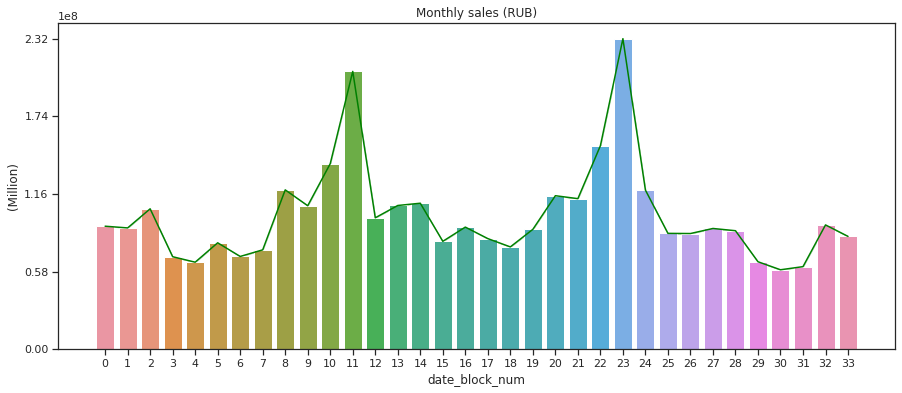

In [26]:
plt.figure(figsize=(15,6))
ax = plt.subplot()
monthly_sales = sns.barplot(x=analysis.date_block_num, y=analysis.month_sales, ax = ax)
monthly_sales.set_title("Monthly sales (RUB)")
monthly_sales.set_yticks(np.arange(0, analysis.month_sales.max() + 1, analysis.month_sales.max()/4))
monthly_sales.set(ylabel = "(Million)")

ms_line = sns.lineplot(x=analysis.date_block_num , y=analysis.month_sales, ax = ax, color='green')

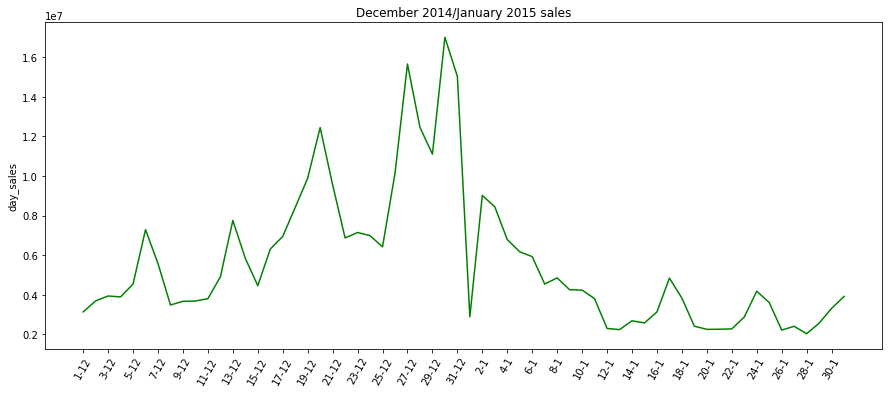

In [8]:
plt.figure(figsize=(15,6))
russianchristmas = analysis.loc[analysis["date_block_num"].isin([23, 24])].groupby(['date'])['day_sales'].sum().reset_index(drop=False)
#x = [x[:2] for x in dec2015.date]
ruschr = sns.lineplot(x=[f"{x.day}-{x.month}" for x in russianchristmas.date], y=russianchristmas.day_sales, color = 'green')
ruschr.set_xticks(ruschr.get_xticks()[::2])
ruschr.set_title("December 2014/January 2015 sales")
plt.xticks(rotation=60)
plt.show()

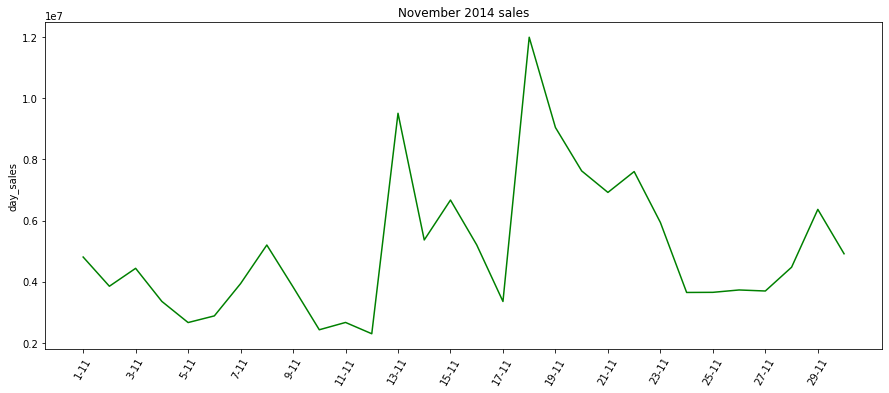

In [9]:
plt.figure(figsize=(15,6))
nov2014 = analysis.loc[analysis["date_block_num"] == 22].groupby(['date'])['day_sales'].sum().reset_index(drop=False)
#x = [x[:2] for x in dec2015.date]
nov2014plot = sns.lineplot(x=[f"{x.day}-{x.month}" for x in nov2014.date], y=nov2014.day_sales, color = 'green')
nov2014plot.set_xticks(nov2014plot.get_xticks()[::2])
nov2014plot.set_title("November 2014 sales")
plt.xticks(rotation=60)
plt.show()

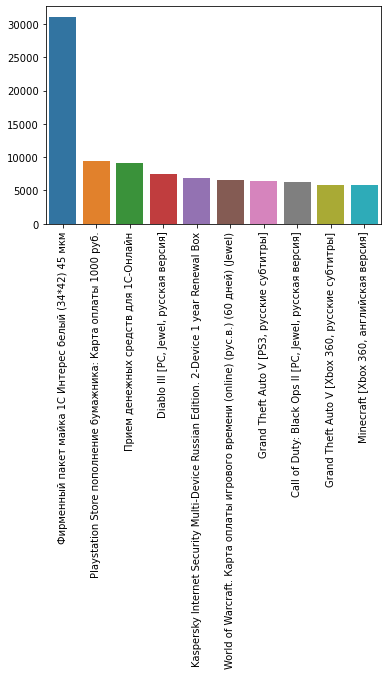

In [56]:
most_popular_items = analysis.item_name.value_counts()[:10]
plt.xticks(rotation = 90)
mpi = sns.barplot(x=most_popular_items.keys(), y=most_popular_items.values)
# First place is a t-shirt packet

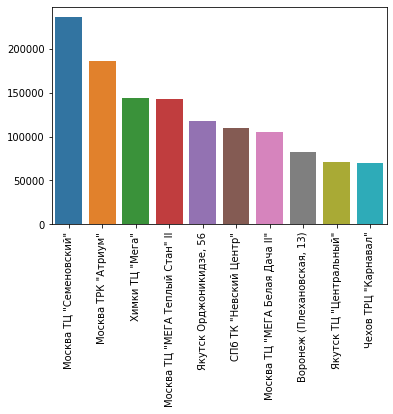

In [11]:
most_popular_shops = analysis.shop_name.value_counts()[:10]
plt.xticks(rotation = 90)
mps = sns.barplot(x=most_popular_shops.keys(), y=most_popular_shops.values)
#top 1, 2, 4, 7 are located in Moscow

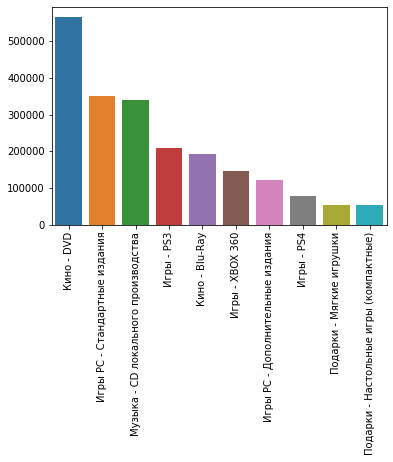

In [12]:
most_popular_cats = analysis.item_category.value_counts()[:10]
plt.xticks(rotation = 90)
mpc = sns.barplot(x=most_popular_cats.keys(), y=most_popular_cats.values)
# Movies, PC games, Music, PS3 games

In [13]:
train = analysis[analysis['item_id'].isin(df_test['item_id'])].reset_index(drop=True)

In [14]:


train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446006 entries, 0 to 1446005
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   date                 1446006 non-null  object 
 1   date_block_num       1446006 non-null  int64  
 2   shop_id              1446006 non-null  int64  
 3   item_id              1446006 non-null  int64  
 4   item_price           1446006 non-null  float64
 5   item_cnt_day         1446006 non-null  float64
 6   day_sales            1446006 non-null  int64  
 7   month_sales          1446006 non-null  int64  
 8   item_name            1446006 non-null  object 
 9   item_category_id     1446006 non-null  int64  
 10  item_category        1446006 non-null  object 
 11  shop_name            1446006 non-null  object 
 12  shop_item_cnt_month  1446006 non-null  float64
dtypes: float64(3), int64(6), object(4)
memory usage: 143.4+ MB


In [15]:
train.shop_item_cnt_month

In [16]:
train['month_sales_cnt'] = train[['date_block_num', 'shop_item_cnt_month']].groupby('date_block_num').transform('sum')

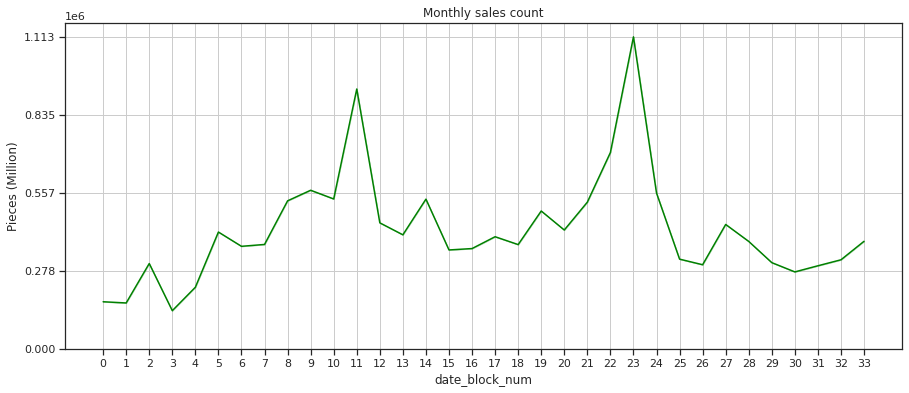

In [17]:
plt.figure(figsize=(15,6))
sns.set(style='ticks')
monthly_count = sns.lineplot(x=train.date_block_num , y=train.month_sales_cnt, color='green')
monthly_count.set_title("Monthly sales count")
monthly_count.set_yticks(np.arange(0, train.month_sales_cnt.max() + 1, train.month_sales_cnt.max()/4))
monthly_count.set_xticks(np.arange(0, 34))
monthly_count.set(ylabel = "Pieces (Million)")
plt.grid()

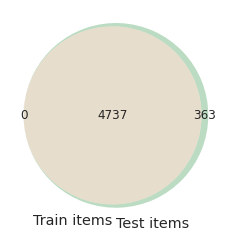

In [18]:
from matplotlib_venn import venn2
venn2([set(train.item_id.unique()), set(df_test.item_id.unique())], set_labels = ('Train items', 'Test items'))
plt.show()

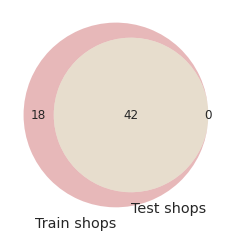

In [19]:
venn2([set(train.shop_id.unique()), set(df_test.shop_id.unique())], set_labels = ('Train shops', 'Test shops'))
plt.show()

### proposals for test features:
- [x] item category ID 
- [x] shop position in popularity (ordinary from 0 to n shops)
- [x] item position in popularity
- [x] category position in popularity
-  shop city?


In [21]:
test = df_test.copy()
test['item_category_id'] = [name_id[x][1] for x in test['item_id']]

In [22]:
def sort_ordinally(dic):
    keys = dic.keys()
    values = dic.values
    last_unique = (0, 0) # (count value, popularity placement)
    order = 0
    for idx, x in enumerate(values):
        if x != last_unique[0]:
            last_unique = (x, order)
            dic[keys[idx]] = order
            order += 1
        else:
            dic[keys[idx]] = last_unique[1]
    return dic

In [23]:
shops_popularity = sort_ordinally(train.shop_id.value_counts())
cats_popularity = sort_ordinally(train.item_category_id.value_counts())
items_popularity = sort_ordinally(train.item_id.value_counts())

In [24]:
test['shop_popularity'] = [shops_popularity[x] for x in test['shop_id']]
test['cat_popularity'] = [cats_popularity[x] if x in cats_popularity else np.NaN for x in test['item_category_id']]
test['item_popularity'] = [items_popularity[x] if x in items_popularity else np.NaN for x in test['item_id']]

In [25]:
# there are 84 entries with new categories and 15246 entries with new items. What to do abouttrain NaNs?
print(test.isna().sum())
test.head()

ID                      0
shop_id                 0
item_id                 0
item_category_id        0
shop_popularity         0
cat_popularity         84
item_popularity     15246
dtype: int64


,ID,shop_id,item_id,item_category_id,shop_popularity,cat_popularity,item_popularity
0,0,5,5037,19,28,3.0,239.0
1,1,5,5320,55,28,0.0,NaN
2,2,5,5233,19,28,3.0,574.0
3,3,5,5232,23,28,4.0,886.0
4,4,5,5268,20,28,5.0,NaN


In [39]:
analysis.shape[0]

2935849

In [40]:
train.shape[0]

1446006

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6debef96-f819-431a-891f-c018cd62f292' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>